In [1]:
# 기본 패키지
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import datetime as dt

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
## 이미지에서 한글이 나오게 하는 설정
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

## 야후 파이낸스 패키지 ## pip install yfinance
import yfinance as yf

## 연준 패키지 ## pip install fredapi
from fredapi import Fred
fred = Fred(api_key='cfb4f49f5c1a9396f671b8049d992e56')
## fred = Fred(api_key='MY API KEY')
## FED API KEY 발급받기
## https://yenpa.tistory.com/65

In [2]:
## 사전 정의한 함수 모음
import graphModule as gm
import myfuncs as mf

## DataLoad

In [3]:
## 필수 데이터

## 사전에 획득한 금, 다우존스배당지수
gold = pd.read_csv(f"gold.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Gold'})
gold.index = pd.to_datetime(gold.index)
div = pd.read_csv(f"div.csv", encoding='utf-8').set_index('Date')[['Close']].rename(columns={'Close':'Div'})
div.index = pd.to_datetime(div.index)
## DFF: Federal Funds Rate, DTB3: 3개월 미국 국채 금리, DGS2: 2년 미국 국채 금리, DGS10: 10년 미국 국채 금리, DGS20: 20년 미국 국채 금리
ds20 = fred.get_series('DGS20')
ds10 = fred.get_series('DGS10')
ds2 = fred.get_series('DGS2').fillna(method='pad')
tb3 = fred.get_series('DTB3').fillna(method='pad')
dff = fred.get_series('DFF').fillna(method='pad')
## rec = fred.get_series('USREC').fillna(method='pad') ## 월간 경기침체 데이터 ## 별도 수집 데이터로 대체

## 기본지수 데이터
## ^IXIC : 나스닥종합주가지수, ^GSPC: S&P500지수, ^DJI: 다우존스지수, GC=F : 금선물지수
tickers = ['^IXIC', '^GSPC', '^DJI', 'GC=F']
df_ref = yf.download(tickers, ignore_tz = True, auto_adjust=True)
df_ref = df_ref['Close']

## 75년 이전에는 Gold 데이터가 없음
df_ref = df_ref['1975':]
df_ref = df_ref.fillna(method = 'pad')
df_ref['Div'] = div['Div'].copy()
df_ref['Gold'] = gold['Gold'].copy()
df_ref['DGS10'] = ds10
df_ref['DGS20'] = ds20
df_ref['DGS2'] = ds2
df_ref['DTB3'] = tb3

[*********************100%%**********************]  4 of 4 completed


## Preprocessing

In [4]:
## Imputation
df_ref_imp = mf.imputation(df_ref, '^GSPC', '^DJI') ## S&P500를 기준으로 다우존스 지수 보간
df_ref_imp = mf.imputation(df_ref_imp, '^DJI', 'Div') ## 다우존스 지수를 기준으로 배당지수 보간
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS20', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS20', 'DGS10', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS10', 'DGS2', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'DGS2', 'DTB3', log_diff=False)
df_ref_imp = mf.imputation(df_ref_imp, 'GC=F', 'Gold') ## 금 선물 가격을 기준으로 금 가격 보간
## column selection
df_ref_imp = df_ref_imp[['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']]

0.9184937349953654
0.8698779253276522
0.8862974392044377
1.0153444626004542
0.6605072643580586
0.7090817634162071
0.9953424146502147


In [5]:
df_ref_scaled = df_ref_imp.copy()
_cols = ['^GSPC', '^DJI', '^IXIC', 'Div', 'Gold']
df_ref_scaled[_cols] = df_ref_scaled[_cols]/df_ref_scaled[_cols].iloc[0] * 100
df_ref_scaled.columns = ['S&P500', 'DowJones', 'NASDAQ', 'Div', 'Gold', 'DTB3', 'DGS2', 'DGS10', 'DGS20']
df_ref_scaled['Cash'] = (df_ref_scaled['DTB3']/100 * 1/252 + 1).shift(1).fillna(1).cumprod() * 100

## Visualization(Basic)

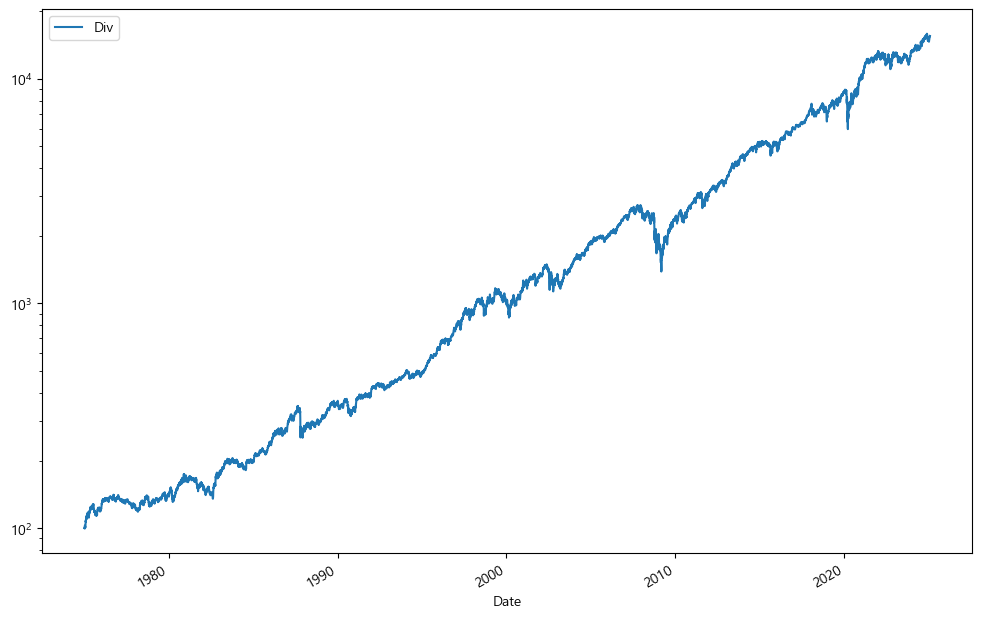

In [12]:
df_ref_scaled[['Div']].plot()
plt.yscale('log')
plt.show()

## gm.trend_plot(df_ref_scaled, ['Div'])

<Axes: ylabel='Frequency'>

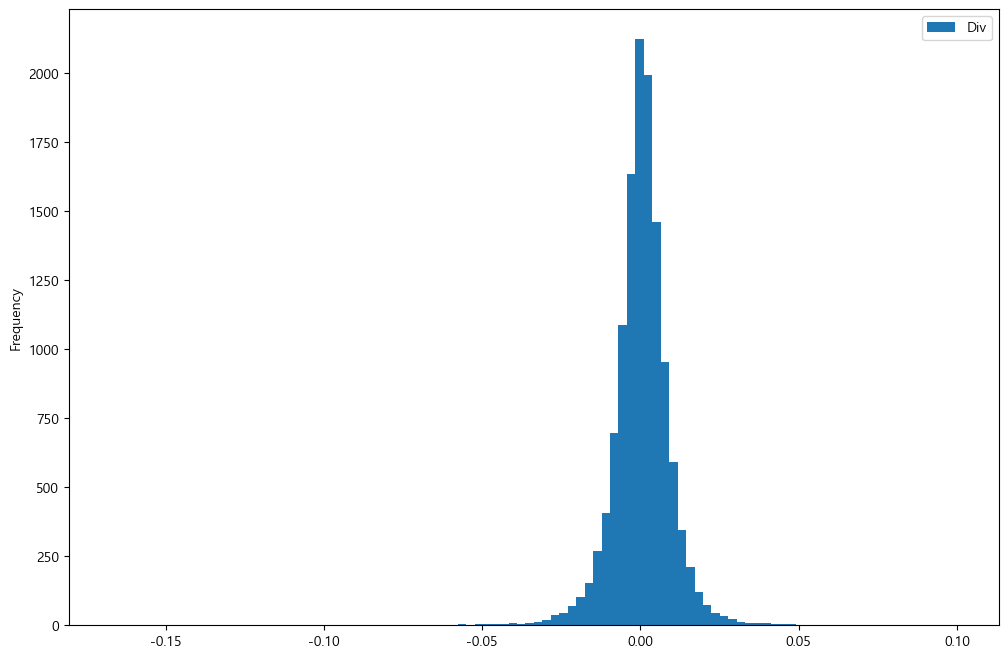

In [16]:
df_ref_scaled[['Div']].pct_change().plot(kind='hist', bins=100)
## gm.asset_histogram_plot(df_ref_scaled.pct_change(), ['Div'])

In [22]:
## MDD 계산
data = df_ref_scaled['Div'].copy()
peak = data.expanding(min_periods=1).max()
drawdown = (data - peak) / peak

<Axes: xlabel='Date'>

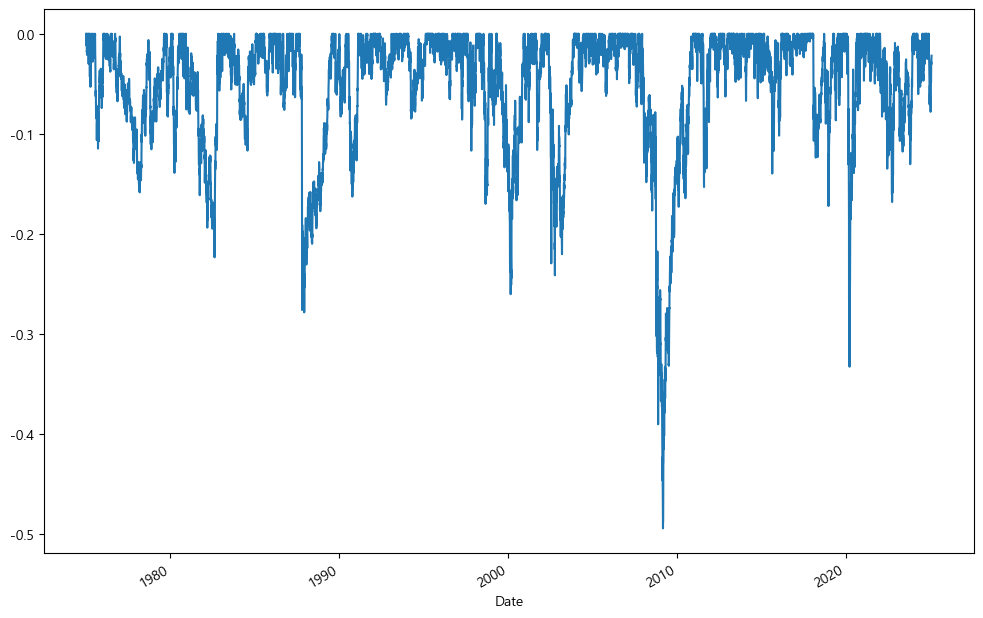

In [25]:
drawdown.plot()
## gm.drawdown_plot(df_ref_scaled, ['Div'])

<Axes: >

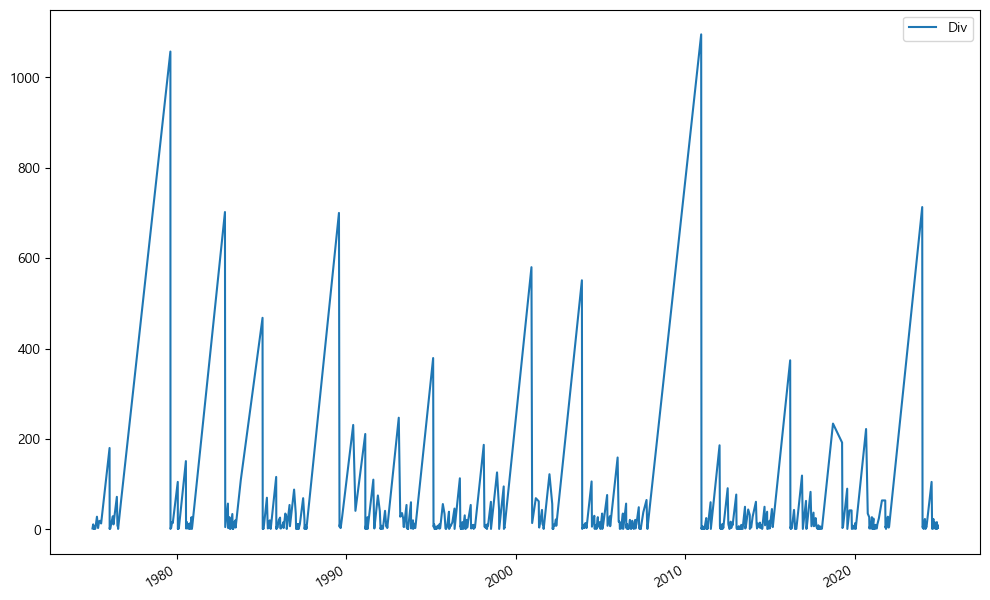

In [30]:
## ttr 계산
ttr_df = mf.get_ttr_df(df_ref_scaled, ['Div'])
ttr_df.plot()
## gm.ttr_plot(ttr_df, ['Div'])

<Axes: >

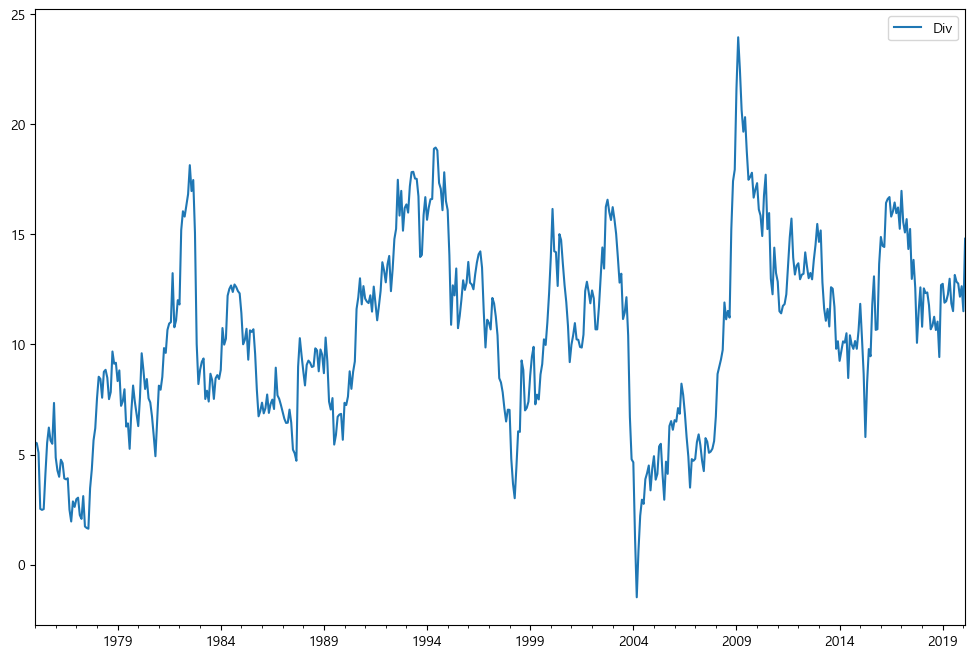

In [32]:
rr_df = mf.get_rr_df(df_ref_scaled, ['Div'])
rr_df.plot()
## gm.rr_trend_plot(rr_df, ['Div'])

<Axes: >

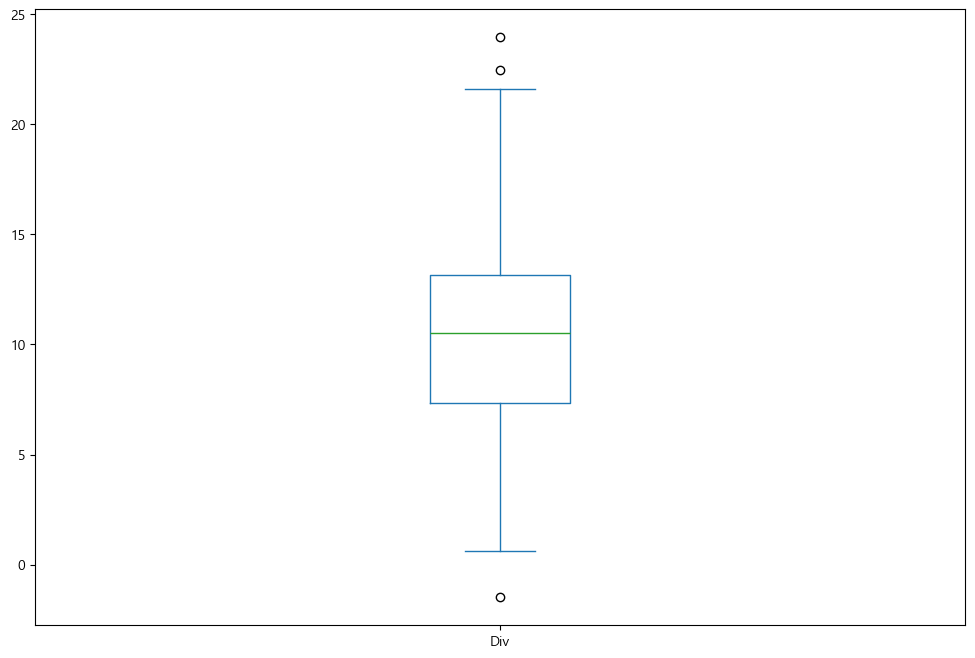

In [34]:
rr_df.plot(kind='box')
## gm.rr_box_plot(rr_df, ['Div'])

In [149]:
import pandas as pd
import numpy as np

def investment_simulation(price_series, monthly_investment, years):
    """
    특정 자산 가격의 월간 시계열 데이터와 일정한 월 투자 금액을 기반으로
    투자 시작 시점별로 n년 동안의 투자 경과를 시뮬레이션하는 함수.

    Parameters:
        price_series (pd.Series): 월 단위 자산 가격 시계열 데이터 (Index: 날짜)
        monthly_investment (float): 매월 투자하는 금액
        years (int): 투자 기간 (년)

    Returns:
        List[pd.DataFrame]: 각 투자 시작 시점별 매월 투자 결과를 포함한 데이터프레임 리스트
    """
    results = []  # 투자 시뮬레이션 결과를 저장할 리스트
    months = years * 12  # 투자 기간을 월 단위로 변환
    
    for start_idx in range(len(price_series) - months):
        start_date = price_series.index[start_idx]  # 투자 시작 월
        end_idx = start_idx + months  # 투자 종료 월
        
        # 투자 기간 내의 가격 데이터 가져오기
        invest_prices = price_series.iloc[start_idx:end_idx+1]
        
        total_invested = 0  # 총 투자 금액
        total_units = 0  # 총 매수한 자산 개수
        records = []  # 매월 기록 저장
        
        for i in range(len(invest_prices)):
            date = invest_prices.index[i]  # 현재 투자 월
            price = invest_prices.iloc[i]  # 해당 월의 가격
            
            # 매월 투자
            total_invested += monthly_investment
            total_units += monthly_investment / price  # 해당 월의 가격으로 매수
            
            # 현재 평가 금액 계산
            final_value = total_units * price
            
            # 기록 저장
            records.append({
                "index": date,
                "Total_Invested": total_invested,
                "Total_Units": total_units,
                "Final_Value": final_value
            })
        
        # 데이터프레임 변환 후 리스트에 저장
        results.append(pd.DataFrame(records).set_index("index"))
    scores = pd.DataFrame([(_df.index[0], (_df['Final_Value'][-1]/_df['Total_Invested'][-1]-1)*100) for _df in results], columns=['index', 'Total_Return']).set_index('index')
    return results, scores

In [158]:
simulations, scores = investment_simulation(df_ref_scaled['NASDAQ'].resample('M').first(), 300*1e4, 30)

In [171]:
min_index = scores[scores['Total_Return'] == scores['Total_Return'].min()].index[0]
min_index = scores.index.get_loc(min_index)

<Axes: xlabel='index'>

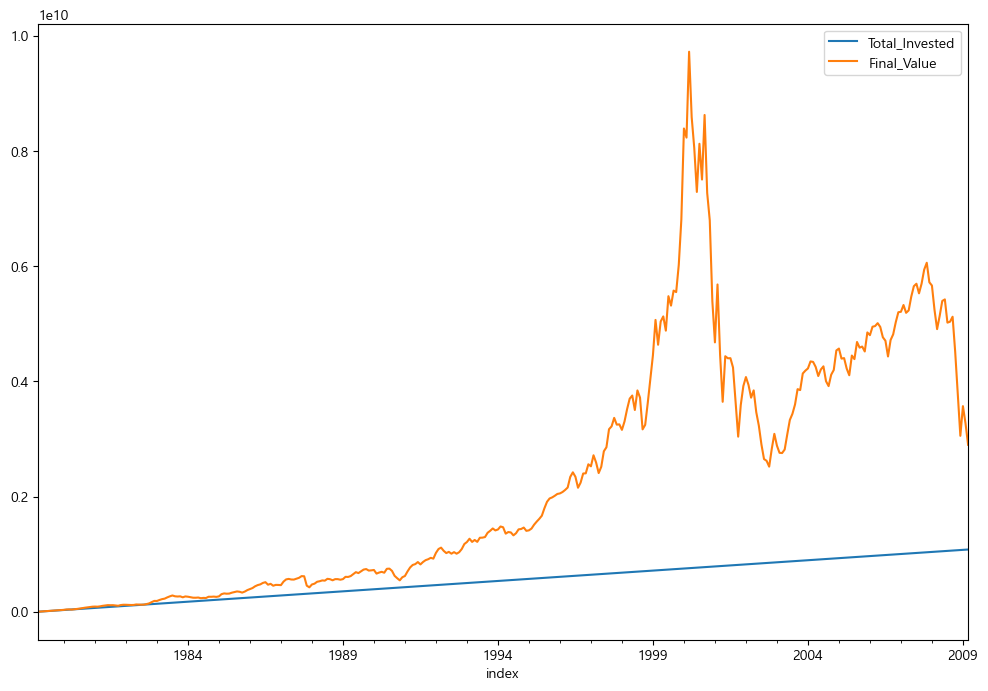

In [174]:
simulations[min_index][['Total_Invested', 'Final_Value']].plot()

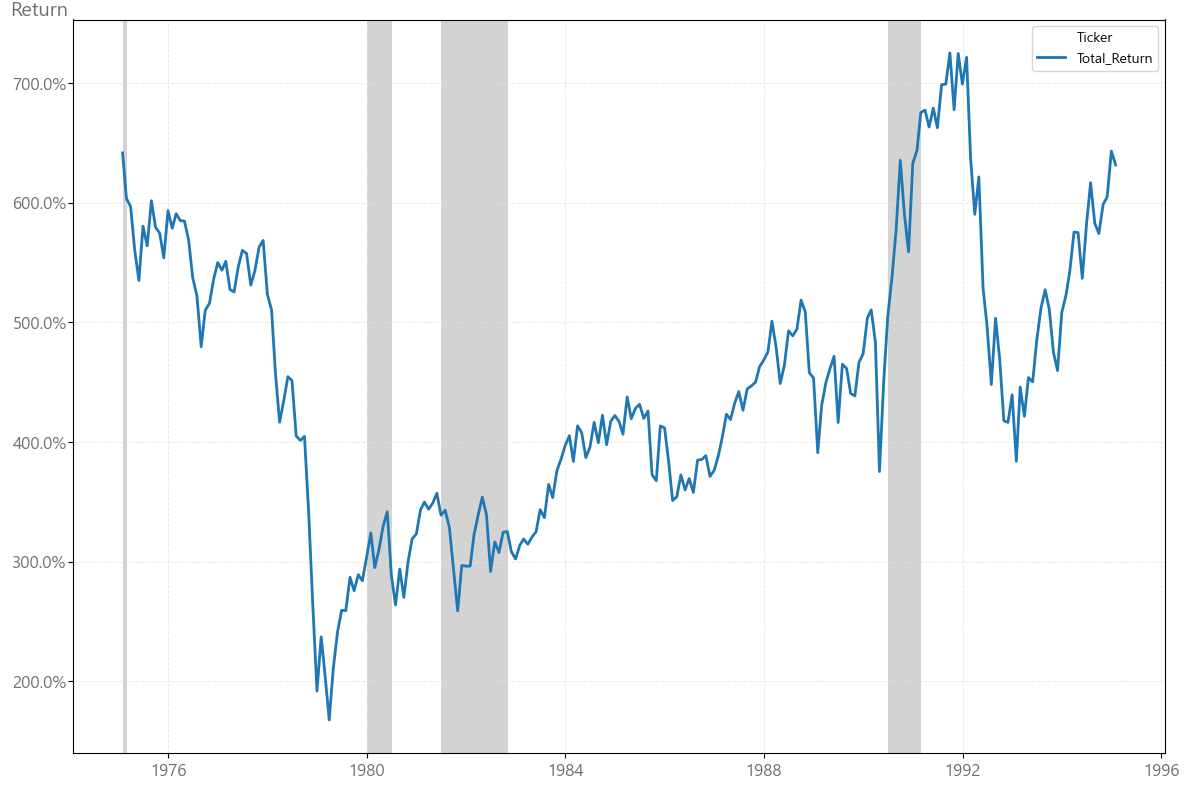

In [160]:
gm.rr_trend_plot(scores, ['Total_Return'], title=False)

Timestamp('1975-01-31 00:00:00')